In [1]:
import sys
sys.path.append("..")

In [2]:
from ultralytics import YOLO
from pathlib import Path
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np
import json
import cv2
from tqdm import tqdm

from picking_robot.utils.optimization import find_similar_box
from picking_robot.utils.processing import pad_rectangle_width, get_width_and_length_points
from picking_robot.utils.calculation import calculate_centroid, angle_with_x_axis, calculate_midpoint

In [3]:
# model = YOLO('yolo11l-seg.pt', task='segment')
model = YOLO('../picking_robot/checkpoint/best.pt', task='segment')

In [4]:
data_dir = Path("../data")
image_dir = data_dir / "images"
annotation_file = data_dir / "annotation.json"
camera_info_file = data_dir / "camera.json"
train_ids_file = data_dir / "train_ids.txt"
test_ids_file = data_dir / "test_ids.txt"

annotation = json.loads(annotation_file.read_text())
camera_info = json.loads(camera_info_file.read_text())
test_ids = test_ids_file.read_text().splitlines()

In [5]:
def imshow(image_bgr: np.ndarray, figsize=(12, 8)):
    """Showing image."""
    rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    # cv2.imwrite("test.png", image_bgr)
    if figsize:
        plt.figure(figsize=figsize)
    plt.imshow(rgb)
    plt.show()

In [6]:
def find_polygons(image_dir, image_id: str, to_bbox=False, pad_width_rate=0.0, show=True):
    """Draw polygons on training image."""
    image_file = image_dir / f"{image_id}.png"
    image_bgr = cv2.imread(image_file.as_posix())

    # GET POLYGON FROM SEGMENTATION MODEL
    det_preds = model.predict(image_file.as_posix(), task='segment', imgsz=640)
    det_masks = det_preds[0].masks.xy
    det_boxes = det_preds[0].boxes.xyxy.cpu().numpy()
    det_labels = det_preds[0].boxes.cls.cpu().numpy().tolist()

    polygons = []
    for idx, (poly, bbox, label_idx) in enumerate(zip(det_masks, det_boxes, det_labels)):
        poly = poly.astype(np.int32)
        xmin, ymin, xmax, ymax = bbox
        bbox = np.array([
            [xmin, ymin],
            [xmax, ymin],
            [xmax, ymax],
            [xmin, ymax]
        ])

        if to_bbox is True: # approximate polygon by rectangle box
            apoly = find_similar_box(poly, bbox)
            apoly = pad_rectangle_width(apoly, padding_rate=pad_width_rate)
        else:
            apoly = poly
    
        center_poly = calculate_centroid(apoly)
        label = model.names[int(label_idx)]
        if label == "top":
            color = (0, 255, 0)  # green
            polygons.append(apoly)  # just get top chip
        else:
            color = (0, 0, 255)  # red
        cv2.polylines(image_bgr, [apoly.astype(np.int32)], True, color, 2)
        cv2.putText(image_bgr, f"{idx}", (int(center_poly[0]), int(center_poly[1])), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 1)

    if show:
        imshow(image_bgr)
    cv2.imwrite(f"../logs/visual/{image_id}.png", image_bgr)
    return polygons


image 1/1 /u01/workspace/hoangph3/Picking-Robot/notebooks/../data/images/148.png: 384x640 23 tops, 7 overlaps, 380.8ms
Speed: 1.5ms preprocess, 380.8ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)


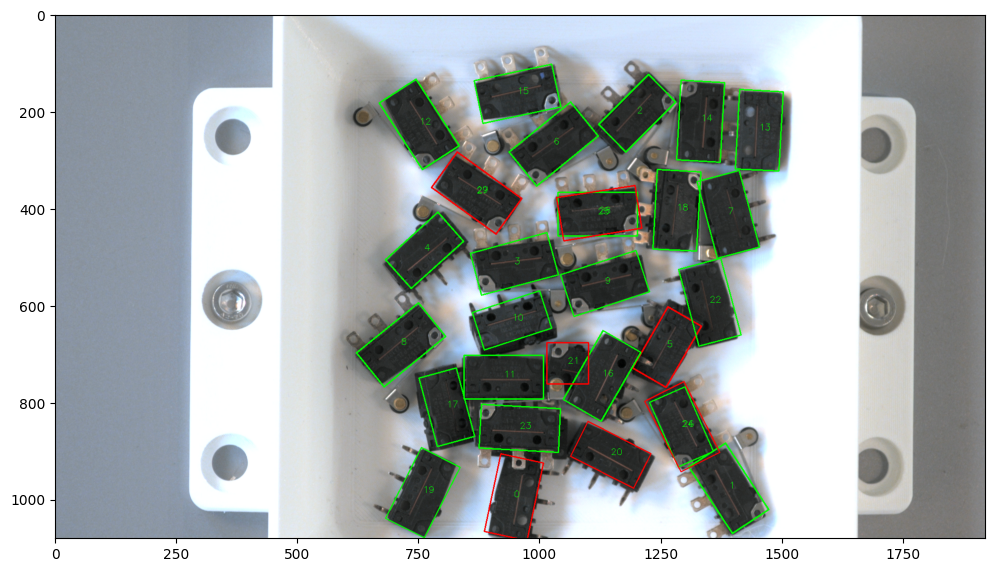

In [7]:
polygons = find_polygons(image_dir, image_id="148", to_bbox=True, pad_width_rate=0.0)

In [10]:
def find_keypoints(image_dir, image_id, show=True):
    image_file = image_dir / f"{image_id}.png"
    image_bgr = cv2.imread(image_file.as_posix())
    gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    # Applying SIFT detector
    sift = cv2.SIFT_create()
    kps = sift.detect(gray, None)

    # Marking the keypoint on the image using circles
    img = cv2.drawKeypoints(gray, kps, None, flags=0)
    if show:
        imshow(img)
    
    keypoints = [(int(kp.pt[0]), int(kp.pt[1])) for kp in kps]
    return keypoints

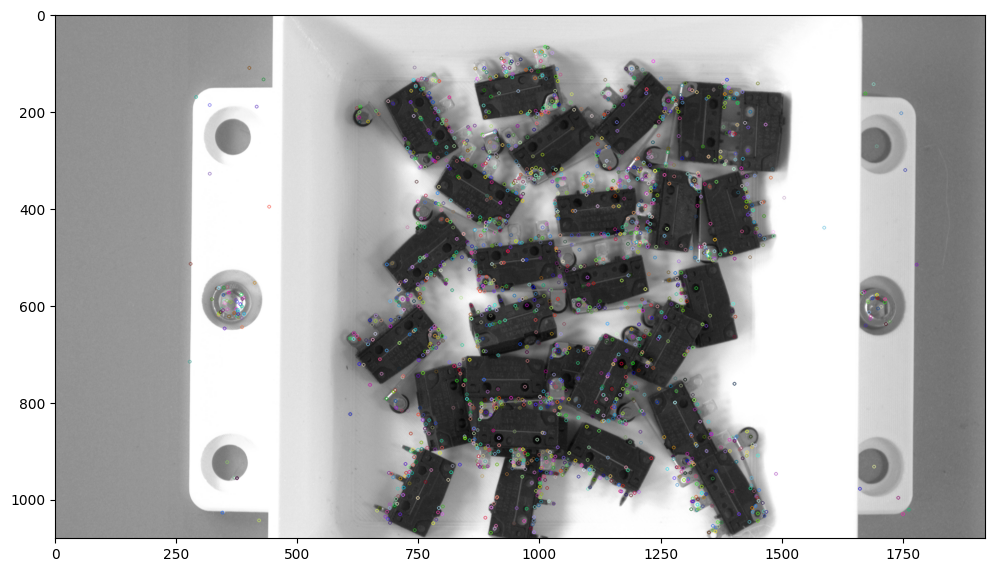

In [11]:
keypoints = find_keypoints(image_dir, image_id="148")

In [28]:
def find_picking_direction(image_dir, image_id, show=True):
    image_file = image_dir / f"{image_id}.png"
    image = cv2.imread(image_file.as_posix())
    polygons = find_polygons(image_dir, image_id, to_bbox=True, pad_width_rate=0.1, show=show)
    keypoints = find_keypoints(image_dir, image_id, show=show)

    if show:
        num_polygons = len(polygons)
        cols = 3  # Number of columns in the subplot grid
        rows = -(-num_polygons // cols)  # Calculate rows needed for the given columns
        fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))
        axes = axes.flatten()

    results = []
    for idx, poly_points in enumerate(polygons):
        width_pairs, length_pairs = get_width_and_length_points(poly_points)
        mid_width = [calculate_midpoint(p1, p2) for p1, p2 in width_pairs]
        mid_length = [calculate_midpoint(p1, p2) for p1, p2 in length_pairs]
        centroid = calculate_midpoint(mid_length[0], mid_length[1])
        polygon_width = []
        for width_points in width_pairs:
            sub_points = list(width_points) + list(mid_length)
            polygon_width.append(np.array(sub_points))

        # COUNT POINT
        polygon_w1, polygon_w2 = polygon_width
        polygon_w1 = Polygon(polygon_w1)
        polygon_w2 = Polygon(polygon_w2)
        point_w1 = 0
        point_w2 = 0
        for kp in keypoints:
            point = Point(kp)
            if polygon_w1.contains(point):
                point_w1 += 1
            if polygon_w2.contains(point):
                point_w2 += 1

        # CHOOSE DIRECTION
        direction_v = [centroid]
        if point_w1 >= point_w2:
            direction_v.append(mid_width[0])
        else:
            direction_v.append(mid_width[1])
        
        # Draw direction on the original image (optional visualization)
        theta = angle_with_x_axis(direction_v[0], direction_v[1])
        results.append([centroid, theta])
        direction_v[0] = list(map(int, direction_v[0]))
        direction_v[1] = list(map(int, direction_v[1]))
        cv2.line(image, direction_v[0], direction_v[1], (255, 0, 0), 5)

        # Create a mask for the polygon and crop the area
        mask = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(mask, [np.array(poly_points, np.int32)], 1)
        cropped_image = cv2.bitwise_and(image, image, mask=mask)

        # Adjust mask to show only the polygon's region
        x, y, w, h = cv2.boundingRect(np.array(poly_points))
        cropped_image = cropped_image[y:y+h, x:x+w]

        # Draw keypoints if they are inside the current polygon
        poly_obj = Polygon(poly_points)
        for kp in keypoints:
            point = Point(kp)
            if poly_obj.contains(point):
                kp_x, kp_y = kp[0] - x, kp[1] - y
                cv2.circle(cropped_image, (kp_x, kp_y), radius=5, color=(0, 255, 0), thickness=-1)

        # Calculate angle and annotate plot
        if show:
            ax = axes[idx]
            ax.imshow(cropped_image[..., ::-1])  # Convert BGR to RGB for matplotlib
            ax.set_title(f"Polygon {idx + 1}\n(cx, cy): {direction_v[0]}\nθ: {theta:.2f}°")
            ax.axis('off')

    if show:
        # Hide unused subplots
        for idx in range(len(polygons), len(axes)):
            axes[idx].axis('off')
        plt.tight_layout()
        plt.show()

    return results


image 1/1 /u01/workspace/hoangph3/Picking-Robot/notebooks/../data/images/148.png: 384x640 23 tops, 7 overlaps, 333.9ms
Speed: 1.3ms preprocess, 333.9ms inference, 11.7ms postprocess per image at shape (1, 3, 384, 640)


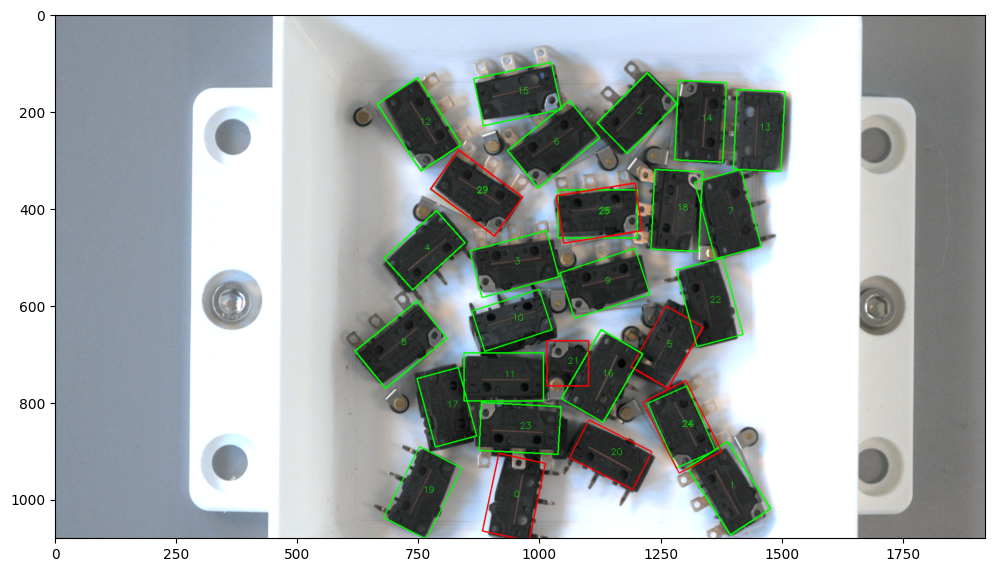

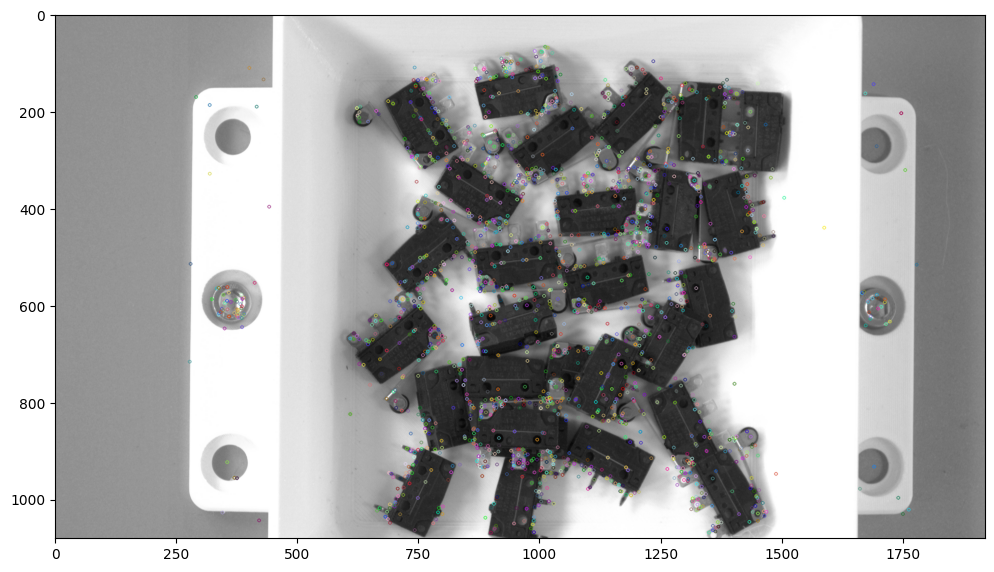

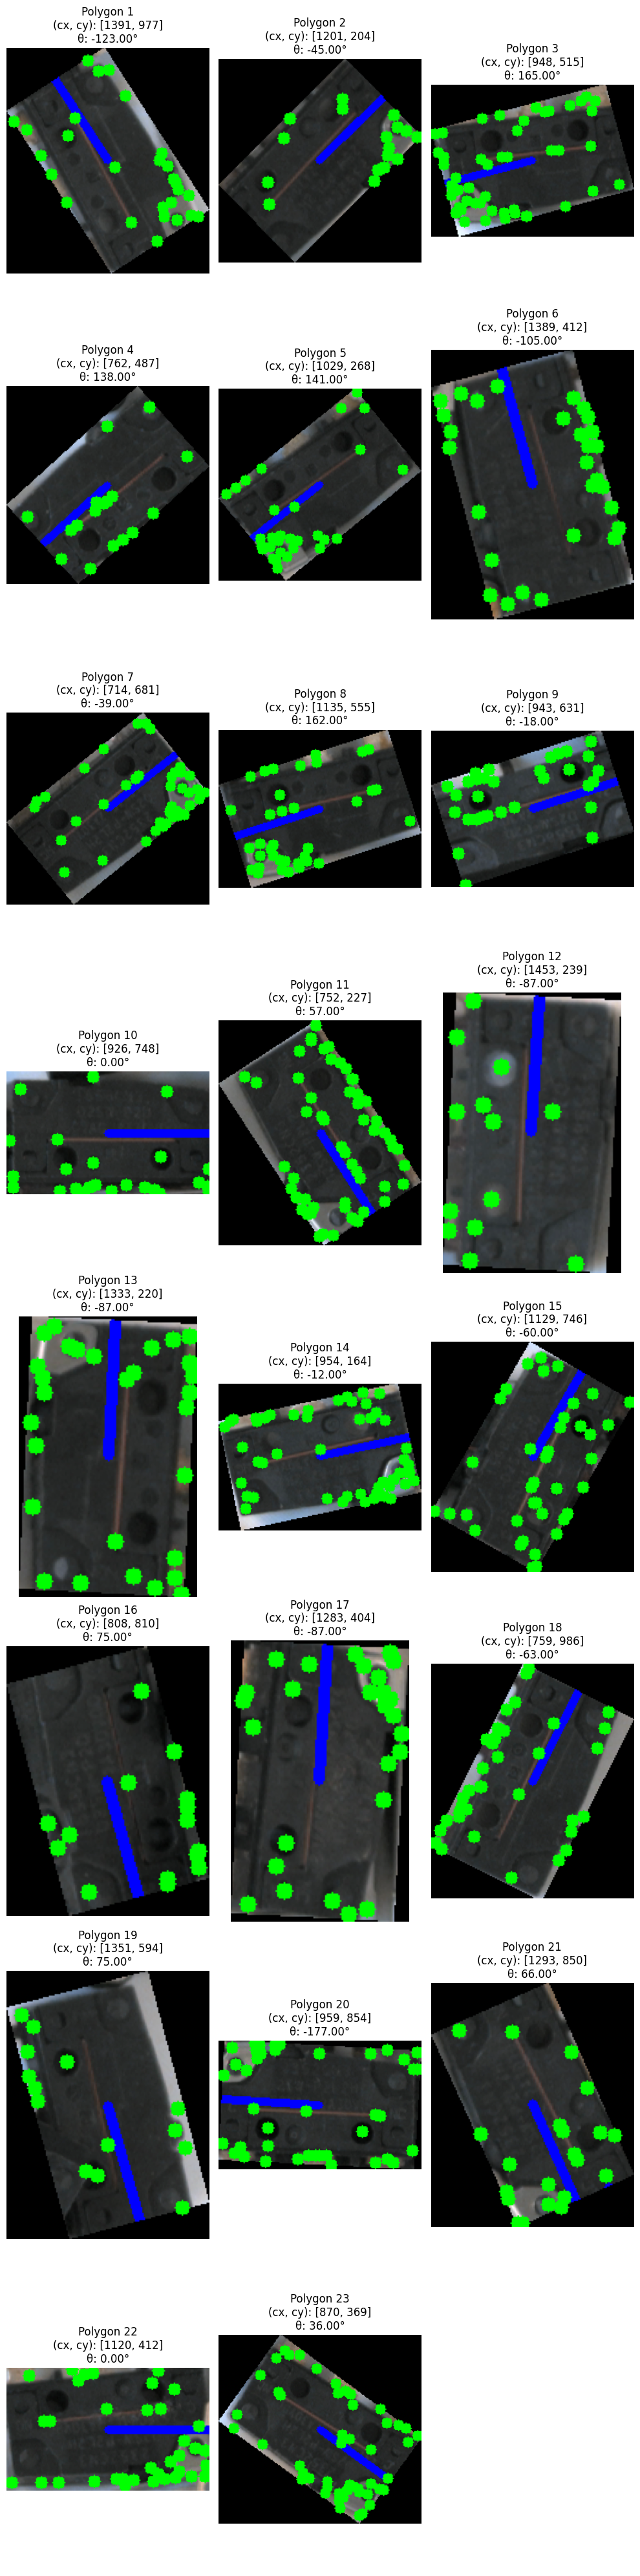

[[(1391.3270874023438, 977.4041748046875), -122.99997052235689],
 [(1201.914306640625, 204.5572967529297), -44.999974524811456],
 [(948.2505493164062, 515.2793273925781), 164.99998692304706],
 [(762.8663940429688, 487.31361389160156), 137.9999818090036],
 [(1029.5855407714844, 268.10203552246094), 141.00001565926723],
 [(1389.9634399414062, 412.8233337402344), -105.00002817335533],
 [(714.7729187011719, 681.5416870117188), -39.00000291628899],
 [(1135.22705078125, 555.2714233398438), 161.99996216921974],
 [(943.5567321777344, 631.5060729980469), -17.99999576434672],
 [(926.5064697265625, 748.3562622070312), 0.0],
 [(752.0565795898438, 227.37034606933594), 56.99998785325658],
 [(1453.850341796875, 239.83055114746094), -87.00004155415387],
 [(1333.015869140625, 220.93295288085938), -86.99995571428357],
 [(954.7158813476562, 164.8715362548828), -12.00000099323502],
 [(1129.681640625, 746.2335815429688), -60.00005431286934],
 [(808.83056640625, 810.4345397949219), 75.00002848779478],
 [(12

In [29]:
find_picking_direction(image_dir, image_id="148")

In [30]:
def solve(image_dir):
    for image_id in test_ids:
        print(f"Solving: {image_id}")
        with open(f"../results/problem_1/{image_id}.txt", "w") as f:
            results = find_picking_direction(image_dir, image_id, show=False)
            for (cx, cy), theta in results:
                res = list(map(float, [cx, cy, theta]))
                res = list(map(str, res))
                f.write(" ".join(res)+"\n")

In [31]:
solve(image_dir)

Solving: 102

image 1/1 /u01/workspace/hoangph3/Picking-Robot/notebooks/../data/images/102.png: 384x640 18 tops, 7 overlaps, 338.9ms
Speed: 1.3ms preprocess, 338.9ms inference, 10.7ms postprocess per image at shape (1, 3, 384, 640)
Solving: 121

image 1/1 /u01/workspace/hoangph3/Picking-Robot/notebooks/../data/images/121.png: 384x640 27 tops, 5 overlaps, 334.9ms
Speed: 1.3ms preprocess, 334.9ms inference, 12.5ms postprocess per image at shape (1, 3, 384, 640)
Solving: 124

image 1/1 /u01/workspace/hoangph3/Picking-Robot/notebooks/../data/images/124.png: 384x640 23 tops, 8 overlaps, 339.3ms
Speed: 1.3ms preprocess, 339.3ms inference, 12.7ms postprocess per image at shape (1, 3, 384, 640)
Solving: 128

image 1/1 /u01/workspace/hoangph3/Picking-Robot/notebooks/../data/images/128.png: 384x640 21 tops, 7 overlaps, 338.4ms
Speed: 1.3ms preprocess, 338.4ms inference, 11.2ms postprocess per image at shape (1, 3, 384, 640)
Solving: 134

image 1/1 /u01/workspace/hoangph3/Picking-Robot/notebooks/